# Language modeling with Jax

April 2021 - Sven Schmit

*For comments / questions / feedback, please [reach out](https://twitter.com/spschmit)!*

In this notebook, we explore simple language models using Jax and [Flax](https://flax.readthedocs.io/en/latest/). In particular, we'll take inspiration from Andrej Karpathy's blog post [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) from 2015. 

While the methods here may be quite old according to deep learning standards, they are also quite simple to implement and play around with.

# New section

In [2]:
import time
from typing import List

import jax
import jax.ops
import jax.numpy as np
import numpy as onp

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax import optim

import matplotlib.pyplot as plt

In [3]:
key = jax.random.PRNGKey(0)

In [5]:
def get_text(fname):
  with open(fname, 'r') as reader:
    data = reader.read()

  return data

def id_bridge(iterable):
  """ provides mapping to and from ids """
  return ({elem: id for id, elem in enumerate(iterable)}, 
          {id: elem for id, elem in enumerate(iterable)})

To get started, we use a very simple and short string of characters to quickly be able to test whether the model is actually learning; it's easy for bugs to go unnoticed, especially while learning.

In [6]:
# very simple example to test model can learn
data = 'abcd...abcd...'

def prep_data(data):
  chars = list(set(data))
  vocab_size = len(chars)
  char_to_id, id_to_char = id_bridge(chars)
  # data converted to ids
  data_id = [char_to_id[char] for char in data]
  return data_id, char_to_id, id_to_char

In [7]:
data_id, char_to_id, id_to_char = prep_data(data)
data_id[:10]

[4, 2, 0, 1, 3, 3, 3, 4, 2, 0]

First we create some convenience functions to translate between characters, indices, and a vector representation.

Note: there would be some room to optimize by using the sparse encoding, rather than creating the 1-hot encoded vector.

In [8]:
def one_hot(i, n):
  """ 
  create vector of size n with 1 at index i
  """
  x = np.zeros(n)
  return jax.ops.index_update(x, i, 1)

def encode(char):
  return one_hot(char_to_id[char], len(char_to_id))

def decode(predictions, id_to_char):
  # for simplicity, pick the most likely character
  # this can be replaced by sampling weighted
  # by the probability of each character
  return id_to_char[int(np.argmax(predictions))]

## A simple recurrent model

Here we define the model from scratch using the Flax library. Note that it would be simple to replace the RNNCell with a different recurrent cell, such as an LSTM cell.

We compose 3 cells to create our character model. We could write this in fancier ways, but sometimes simple is good enough.

In [9]:
class RNNCell(nn.Module):
  @nn.compact
  def __call__(self, state, x):
    # Wh @ h + Wx @ x + b can be efficiently computed
    # by concatenating the vectors and then having a single dense layer
    x = np.concatenate([state, x])
    new_state = np.tanh(nn.Dense(state.shape[0])(x))
    return new_state

class ChaRNN(nn.Module):
  state_size: int
  vocab_size: int

  @nn.compact
  def __call__(self, state, i):
    x = one_hot(i, self.vocab_size)
    new_state = []

    # a rather naive way of stacking multiple RNN cells
    new_state_1 = RNNCell()(state[0], x)
    new_state_2 = RNNCell()(state[1], new_state_1)
    new_state_3 = RNNCell()(state[2], new_state_2)
    predictions = nn.softmax(nn.Dense(self.vocab_size)(new_state_3))
    return [new_state_1, new_state_2, new_state_3], predictions

  def init_state(self):
    # a convenient way to initialize the state
    return [np.zeros(self.state_size), np.zeros(self.state_size), np.zeros(self.state_size)]

Next, we write a simple sampling function to generate samples based on the model, generating characters sequentially.

In [ ]:
def sample(model, params, bridge, initial='', max_length=100):
  """
  Sample from the model by greedily selecting next characters

  To do: make more efficient by JIT-ing
  """
  char_to_id, id_to_char = bridge
  state = model.init_state()
  output = initial
  for char in initial[:-1]:
    state, _ = model.apply(params, state, char_to_id[char])

  next_char = initial[-1]
  for i in range(max_length):
    state, predictions = model.apply(params, state, char_to_id[next_char])
    next_char = decode(predictions, id_to_char)
    output += next_char

  return output


Before proceeding, let's instantiate a model and sample based on the random instantiation. Random in, random out :)

In [ ]:
state_size = 8

key, subkey = jax.random.split(key)
model = ChaRNN(state_size, len(char_to_id))
params = model.init(subkey, model.init_state(), 0)

print(f"Model state size: {model.state_size}, vocab size: {model.vocab_size}")

# run a single example through the model to test that it works
new_state, predictions = model.apply(params, model.init_state(), 0)
assert predictions.shape[0] == model.vocab_size

Model state size: 8, vocab size: 5


In [ ]:
# calling sample on random model leads to random output
sample(model, params, (char_to_id, id_to_char), 'abc', max_length=10)

'abcdda.dd..a.'

## Training loop

Next up, we write functions to train the model.

The chunker splits the data into batches with inputs, and the target characters, which are the inputs shifted by 1: we want to predict the next character.

In Jax we can define the loss function in terms of a single sample, and then use `vmap` to vectorize.

`rnn_loss` computes the loss over a vector of inputs and targets. The [`jax.lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) function allows us to write the sequential loop over the inputs succinctly, and helps Jax compile the function more easily.

We then use `jax.value_and_gradient` to obtain a function that both evaluates the function and its gradient: the workhorse of our training loop. We compile this function to improve iteration speed.

Once this is written, a batch step becomes trivial: compute the loss, and update the parameters of our model.



In [ ]:
def chunker(seq, size):
  """ 
  chunks a sequences into two subsequences
  one for inputs, another for targets, by
  shifting the input by 1
  """
  n = len(seq)
  p = 0
  while p + 1 <= n:
    # ensure the last chunk is of equal size
    yield seq[p:min(n-1, p+size)], seq[(p+1):(p+size+1)]
    p += size

def cross_entropy_loss(predictions, label):
  # note we compute the loss for a single example.
  # we will use vmap below to vectorize
  return -np.log(predictions[label])

def rnn_loss(params, model, state, inputs, targets):
  # use lax.scan to efficiently generate a loop over the inputs
  # this function returns thefinal state, and predictions for every step
  # note: scan input array needs have shape [length, 1]
  final_state, predictions = jax.lax.scan(lambda state, x: model.apply(params, state, x), 
                                          state, 
                                          np.array([inputs]).T)
  loss = np.mean(jax.vmap(cross_entropy_loss)(predictions, np.array([targets]).T))
  return loss, final_state

# we want both the loss and gradient, we set has_aux because rnn_loss also return final state
# use static_argnums=1 to indicate that the model is static; 
# a different model input will require recomplication
# finally, we jit the function to improve runtime
rnn_loss_grad = jax.jit(jax.value_and_grad(rnn_loss, has_aux=True), static_argnums=1)

def batch_step(model, optimizer, state, inputs, targets):
  (loss, state), grad = rnn_loss_grad(optimizer.target, model, state, inputs, targets)
  new_optimizer = optimizer.apply_gradient(grad)
  return new_optimizer, loss, state

def epoch_step(model, optimizer, data, batch_size):
  state = model.init_state()
  total_loss = 0
  for n, (inputs, targets) in enumerate(chunker(data, batch_size)):
    optimizer, loss, state = batch_step(model, optimizer, state, inputs, targets)

    total_loss += loss
  return optimizer, total_loss / (n+1)

There is little to the train function below: we gather some parameters, instantiate the optimizer, do some logging, but mostly call `epoch_step` to do the hard work.

In [ ]:
def random_subset(data, size, key):
  size = min(len(data), size)
  start_idx = jax.random.randint(key, [1], minval=0, maxval=len(data)-size)[0]
  return data[start_idx:(start_idx+size)]

def train(data, 
          model, 
          initial_params, 
          n_epochs,
          learning_rate=2e-3,
          weight_decay=0.0,
          batch_size=64, 
          max_epoch_size=5000,
          print_every=5,
          sample_every=10,
          sample_prompt=None,
          sample_length=50,
          random_key=key):
  if sample_prompt is None:
    # default: first characters of dataset
    sample_prompt = data[:4]

  print(f"Training RNN on '{data[:10]}...'")
  data_id, char_to_id, id_to_char = prep_data(data)
  print(f"Vocabulary size: {len(char_to_id)}")
  print(f"State size: {model.state_size}")
  optimizer_def = optim.Adam(learning_rate=learning_rate, 
                             weight_decay=weight_decay)
  print("Adam optimizer parameters")
  print(f"learning_rate={learning_rate:.3f}")
  print(f"weight_decay={weight_decay:.3f}")
  print('='*20)

  optimizer = optimizer_def.create(initial_params)
  losses = []

  for epoch in range(n_epochs):
    # start at a random point in data
    # looping over all data takes too long
    random_key, subkey = jax.random.split(random_key)
    epoch_data = random_subset(data_id, max_epoch_size, subkey)
    
    epoch_start = time.time()
    optimizer, avg_loss = epoch_step(model, 
                                     optimizer, 
                                     epoch_data, 
                                     batch_size)
    losses.append(avg_loss)

    # logging
    if not epoch % print_every:
      print(f'Epoch: {epoch:3d} loss: {avg_loss:.3f} time: {time.time() - epoch_start:.2f}')
    if not epoch % sample_every:
      print('Sample:', sample(model, optimizer.target, (char_to_id, id_to_char), 
                              sample_prompt, max_length=sample_length))
    
  return optimizer, losses, (char_to_id, id_to_char)

## Testing on a simple example

Once we put everything together, the first step is to run the small model we created above on some very simple data to make sure that it all works; I missed a transpose in the `lax.scan` which didn't throw an error, but made it impossible for the model to learn anything (also it ran a lot slower).

In [ ]:
result, losses, bridge = train('abcd...abcd...', model, params, 200, sample_every=40)

Training RNN on 'abcd...abc...'
Vocabulary size: 5
State size: 8
Adam optimizer parameters
learning_rate=0.002
weight_decay=0.000
Epoch:   0 loss: 1.577 time: 1.69
Sample: abcdda.dd..a..a..a..a..a..a..a..a..a..a..a..a..a..a..a
Epoch:   5 loss: 1.455 time: 0.06
Epoch:  10 loss: 1.356 time: 0.06
Epoch:  15 loss: 1.262 time: 0.06
Epoch:  20 loss: 1.174 time: 0.06
Epoch:  25 loss: 1.090 time: 0.06
Epoch:  30 loss: 1.010 time: 0.06
Epoch:  35 loss: 0.936 time: 0.06
Epoch:  40 loss: 0.869 time: 0.06
Sample: abcd....dd......d.....................................
Epoch:  45 loss: 0.806 time: 0.06
Epoch:  50 loss: 0.748 time: 0.06
Epoch:  55 loss: 0.693 time: 0.06
Epoch:  60 loss: 0.643 time: 0.06
Epoch:  65 loss: 0.596 time: 0.06
Epoch:  70 loss: 0.553 time: 0.06
Epoch:  75 loss: 0.513 time: 0.06
Epoch:  80 loss: 0.475 time: 0.06
Sample: abcd...abcd...abcd...abcd...abcd...abcd...abcd...abcd.
Epoch:  85 loss: 0.440 time: 0.06
Epoch:  90 loss: 0.408 time: 0.05
Epoch:  95 loss: 0.377 time: 0.06
E

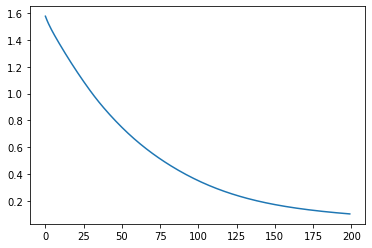

In [ ]:
plt.plot(losses)

## Training on actual data

Now that we have confirmed the RNN can pick up on some simple pattern, let's aim it at something meatier. Here, we use Kafka's Metamorphosis, which we can download from [Project Gutenberg](http://www.gutenberg.org/files/5200/5200-0.txt).

In [ ]:
kafka = get_text('kafka.txt')

state_size = 128
vocab_size = len(set(kafka))

key, subkey = jax.random.split(key)
model = ChaRNN(state_size, vocab_size)
params = model.init(subkey, model.init_state(), 0)

print(f"Model state size: {model.state_size}, vocab size: {model.vocab_size}")

result, losses, bridge = train(kafka, model, params, 400, 
                               batch_size=256,
                               max_epoch_size=10000,
                               weight_decay=1e-7, 
                               sample_every=25, sample_prompt="Gregor")

Model state size: 128, vocab size: 64
Training RNN on 'I


One mo...'
Vocabulary size: 64
State size: 128
Adam optimizer parameters
learning_rate=0.002
weight_decay=0.000
Epoch:   0 loss: 3.134 time: 7.32
Sample: Gregor to  to  oe to  oe  oe to  te  oe to  te  oe  oe t
Epoch:   5 loss: 2.329 time: 3.34
Epoch:  10 loss: 2.042 time: 3.34
Epoch:  15 loss: 2.031 time: 3.24
Epoch:  20 loss: 1.756 time: 3.27
Epoch:  25 loss: 1.663 time: 3.25
Sample: Gregor and her her the was not her the was not her the w
Epoch:  30 loss: 1.687 time: 3.22
Epoch:  35 loss: 1.641 time: 3.23
Epoch:  40 loss: 1.527 time: 3.27
Epoch:  45 loss: 1.590 time: 3.24
Epoch:  50 loss: 1.614 time: 3.25
Sample: Gregor was of the father was of the father was of the fa
Epoch:  55 loss: 1.488 time: 3.25
Epoch:  60 loss: 1.411 time: 3.25
Epoch:  65 loss: 1.495 time: 3.35
Epoch:  70 loss: 1.589 time: 3.21
Epoch:  75 loss: 1.467 time: 3.30
Sample: Gregor’s bone the could have the could have the could ha
Epoch:  80 loss: 1.459 ti

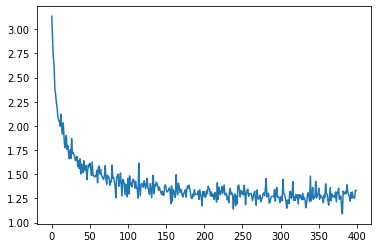

In [ ]:
plt.plot(losses)

In [ ]:
sample(model, result.target, bridge, initial='Gregor', max_length=500)

'Gregor’s father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had been to his father and he had'